# Classification approach
## Giang Dang 17055511 g.dang.17@ucl.ac.uk
## Pier Francesco Procacci 17075285 pier.procacci.17@ucl.ac.uk

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

### Calculate Momentum

In [2]:
''' Import and save dates '''
dates = np.loadtxt("index_price.csv", delimiter=",", usecols=(0), dtype=object)
dates = dates[1:]
dates_w = dates[0:-1:5]
np.save('dates_w',dates_w)

In [3]:
''' Import Components and compute returns '''
data = np.genfromtxt('s_and_p.csv', delimiter=',')
daily_pr = data[1:,1:]
N_stock = daily_pr.shape[1]
ret_d = np.diff(np.log(daily_pr),axis=0)
ret_d[np.isnan(ret_d)] = 0 #Nan values set to 0. it will correspond to carry over when cumulating
ret_w = np.sum(np.reshape(ret_d, (int(ret_d.shape[0]/5), 5, N_stock)), axis=1)

In [4]:
''' Import Index and compute returns '''
index = np.genfromtxt('index_price.csv', delimiter=',')
index_pr = index[0:,1:]
index_ret_d = np.diff(np.log(index_pr),axis=0)
index_ret_d[np.isnan(index_ret_d)] = 0 #Nan values set to 0. it will correspond to carry over when cumulating
index_ret_w = np.sum(np.reshape(index_ret_d, (int(index_ret_d.shape[0]/5), 5)), axis=1)

In [5]:
''' Create 3D Tensor of sliding windows '''
ret_w_sliding = np.zeros([ret_w.shape[0]-51,52,ret_w.shape[1]])
ret_d_sliding = np.zeros([ret_d.shape[0]-19,20,ret_d.shape[1]])

for i in range(0, len(ret_w)-51):
    ret_w_sliding[i,:,:] = ret_w[i:i+52,:]
     
for i in range(0, len(ret_d)-19):
    ret_d_sliding[i,:,:] = ret_d[i:i+20,:]
    
ret_w_sliding = ret_w_sliding[0:-4,:,:]
ret_d_sliding = ret_d_sliding[((52*5)):,:,:]
ret_d_sliding = ret_d_sliding[np.arange(0,ret_d_sliding.shape[0],5),:,:]

In [6]:
''' Compute cumulative returns (over rows) '''
cumRet_d = np.cumsum(ret_d_sliding,1)
cumRet_w = np.cumsum(ret_w_sliding,1)

In [7]:
''' Compute cross-section mean and standard deviation '''
mean_d = np.mean(cumRet_d,2)
mean_w = np.mean(cumRet_w,2)
std_d = np.std(cumRet_d,2)
std_w = np.std(cumRet_w,2)

In [8]:
''' Compute cross-sectional Z-scores (normalization) '''
d_Zscore = (cumRet_d - np.tile(mean_d[:,:,np.newaxis],(1,1,cumRet_d.shape[2]))) / np.tile(std_d[:,:,np.newaxis],(1,1,cumRet_d.shape[2]))
w_Zscore = (cumRet_w - np.tile(mean_w[:,:,np.newaxis],(1,1,cumRet_w.shape[2]))) / np.tile(std_w[:,:,np.newaxis],(1,1,cumRet_w.shape[2]))

In [9]:
''' Compute output labels '''
Y_w = np.ones(ret_w[55:,:].shape)
Y_w = Y_w*ret_w[55:,:]
Y_median = np.median(Y_w,1)
Y_w[Y_w>=np.tile(Y_median[:,np.newaxis],N_stock)] = 1
Y_w[Y_w<np.tile(Y_median[:,np.newaxis],N_stock)] = 0

In [10]:
''' Rename and define training and test set '''
X_w = w_Zscore
X_d = d_Zscore

In [11]:
X_train0 = X_w[0:800,:,:]
X_valid0 = X_w[800:,:,:]

y_train0 = Y_w[0:800,:]
y_valid0 = Y_w[800:,:]

In [12]:
''' Save variables to be used to run the architecture '''
np.save('X_train0',X_train0)
np.save('X_valid0',X_valid0)
np.save('y_train0',y_train0)
np.save('y_valid0',y_valid0)

np.save('ret_w',ret_w)
np.save('index_ret_w',index_ret_w)

### Training with Convolutional LSTM

In [13]:
# train
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, BatchNormalization
from keras.layers.core import Permute, Reshape

Using TensorFlow backend.


In [14]:
''' Load data set '''
X_train0 = np.load('X_train0.npy')
X_valid0 = np.load('X_valid0.npy')
y_train0 = np.load('y_train0.npy')
y_valid0 = np.load('y_valid0.npy')

In [15]:
''' Model Inputs Definition '''
dropout_rate = 0.5
num_classes = 2
_, win_len, dim = X_train0.shape

num_feat_map = 32
batch_size = 16
num_hidden_lstm = 64
epochs = 5

In [16]:
def _data_reshaping(X_tr, X_va):
    _, win_len, dim = X_tr.shape         
    # make it into (frame_number, dimension, window_size, channel=1) for convNet
    X_tr = np.swapaxes(X_tr,1,2)
    X_va = np.swapaxes(X_va,1,2)
 
    X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
    X_va = np.reshape(X_va, (-1, dim, win_len, 1))
    return X_tr, X_va

In [17]:
X_train, X_valid = _data_reshaping(X_train0, X_valid0)

In [18]:
Prediction = np.zeros([dim,len(X_valid),2])
F1 = np.zeros([dim,1])

In [19]:
for i in range(dim): 
      
    y_train = keras.utils.to_categorical(y_train0[:,i], num_classes)
    y_valid = keras.utils.to_categorical(y_valid0[:,i], num_classes)

    print('\n\nstock number:',i,'\n')
    
    
    '''Building architecture '''
    model = Sequential()  
    
    model.add(Conv2D(num_feat_map, (3, 3), padding='same',activation='relu', input_shape=(dim, win_len, 1)))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(dropout_rate))
    #model.add(BatchNormalization())
    #model.add(Conv2D(16, (3, 3), padding='same',activation='elu'))
    #model.add(MaxPooling2D(pool_size=(1, 2)))
    #model.add(Dropout(dropout_rate))
    
    model.add(Permute((2, 1, 3))) # for swap-dimension
    model.add(Reshape((-1,num_feat_map*dim)))
    #model.add(LSTM(32, return_sequences=True, stateful=False))
    #model.add(Dropout(dropout_rate))    
    model.add(LSTM(32, return_sequences=False, stateful=False))
    model.add(Dropout(dropout_rate))
    #model.add(BatchNormalization())
    
    model.add(Dense(2, activation='softmax'))
    
#    model.summary()
    model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
    h = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(X_valid, y_valid))
    Prediction[i,:,:] = model.predict(X_valid)
    
    del model
    del h
    
np.save('Prediction',Prediction)



stock number: 0 

Train on 800 samples, validate on 404 samples
Epoch 1/5
 32/800 [>.............................] - ETA: 49s - loss: 0.6960 - acc: 0.5625

KeyboardInterrupt: 

### Long/Short Strategy

In [20]:
# back test
from matplotlib import pyplot as plt

In [21]:
''' Import Data '''
Prediction = np.load('Prediction.npy')
ret_w = np.load('ret_w.npy')
index_ret_w = np.load('index_ret_w.npy')
dates = np.load('dates_w.npy')
dates = dates[801+55:]

ret_w = ret_w[801+55:,:] #Returns corresponding to validation set
index_ret_w = index_ret_w[801+55:]

In [22]:
''' Consider only prediction above treshold '''
port_long = Prediction[:,:,0]>0.65
port_short = Prediction[:,:,1]>0.80 #short difficult to forecast...

In [23]:
''' build an equally weighted portfolio for prediction above median '''
port_long = np.swapaxes(port_long,0,1)
N_long_pos = np.sum(port_long,1)
N_long_pos[N_long_pos==0] = 1
port_long = port_long/N_long_pos[:,np.newaxis]

In [24]:
''' build an equally weighted portfolio for prediction below median '''
port_short = np.swapaxes(port_short,0,1)
N_short_pos = np.sum(port_short,1)
N_short_pos[N_short_pos==0] = 1
port_short = port_short/N_short_pos[:,np.newaxis]

long_strategy = np.sum(ret_w*port_long,1)
short_strategy = np.sum(-ret_w*port_short,1)

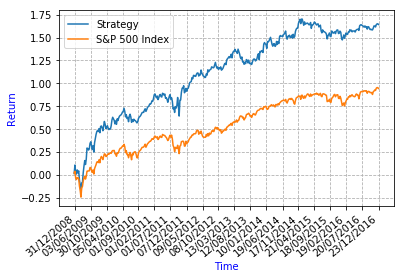

In [25]:
''' Plot Results '''

n_dates = 20

f, (ax1) = plt.subplots(1, 1, sharey=False)
ax1.plot(np.cumsum(long_strategy[:])+np.cumsum(short_strategy[:]), label='Strategy')
ax1.plot(np.cumsum(index_ret_w[:]), label='S&P 500 Index')
ax1.grid(linestyle='--')
ax1.set_ylabel('Return', color='b')
ax1.set_xlabel('Time', color='b')
ax1.legend()
ax1.get_xaxis().set_ticks(np.linspace(1,len(dates)-1,n_dates).astype(int))
ax1.get_xaxis().set_ticklabels(dates[np.linspace(1,len(dates)-1,n_dates).astype(int)])
f.autofmt_xdate(bottom=0.2, rotation=40, ha='right')
plt.show()